<a href="https://colab.research.google.com/github/dTenebrae/neural_networks/blob/hw3/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Практическое задание

  1. Постройте нейронную сеть(берем простую линейную сеть, которую разбирали на уроке: меняем число слоев, число нейронов , типы активации, тип оптимизатора)  на датасет from sklearn.datasets import load_boston. 
  2. Измените функцию потерь и метрику для этой задачи. Постройте 10-15 вариантов и сведите результаты их работы в таблицу  Опишите, какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?

  3. Поработайте с документацией TensorFlow 2. Найти 2-3 полезные команды TensorFlow, не разобранные на уроке (полезные для Вас).

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

import tensorflow as tf
from  tensorflow.keras import Model
from tensorflow.keras.utils import Progbar
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import normalize
from tensorflow.keras.optimizers import SGD, RMSprop, Nadam, Adam, Adagrad

from sklearn.metrics import r2_score

___

In [2]:
def create_model(input_shape, level, neuron):
    inputs = Input(shape=INPUT_SHAPE, name="input_layer")
    x = Dense(neuron, name='dense_1')(inputs)
    for i in range(level):
        x = Dense(neuron, name=f'dense_{i + 2}')(x)
        x = tf.nn.relu(x)

    outputs = Dense(1, name='predictions')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [3]:
def train_step(features, labels):
    with tf.GradientTape() as tape:
        # предскажем значения
        predictions = model(features, training=True)
        # найдем лосс между ними и истинными значениями
        loss_value = loss(labels, predictions)
    # вычислим градиент
    gradients = tape.gradient(loss_value, model.trainable_variables)
    # прогоним оптимизатором по весам (backpropagation)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss_value, metric(labels, predictions)

def test_step(features, labels):
    predictions = model(features, training=False)
    loss_value = loss(labels, predictions)
    return loss_value, metric(labels, predictions)

In [4]:
def input_fn_train(X, y, batch_size=32, repeat=1, shuffle=False):
    # Returns tf.data.Dataset of (x, y) tuple where y represents label's class
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds.shuffle(100)
    ds = ds.batch(batch_size).repeat(repeat)
    return ds

def input_fn_eval(X, y, batch=32):
    # Returns tf.data.Dataset of (x, y) tuple where y represents label's class
    return tf.data.Dataset.from_tensor_slices((X, y)).batch(batch)

___

In [5]:
# Разобьем данные на трейн и тест. По умолчанию на тест иде 20% выборки
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.boston_housing.load_data()
clear_output()

In [6]:
# для избежания разлета градиента нормализуем данные
X_train, X_test = normalize(X_train), normalize(X_test)
# Запишем количество фичей в константу. Потребуется для входного слоя сети
INPUT_SHAPE = X_train.shape[1]

In [7]:
# Упакуем данные в tf dataset
train_ds = input_fn_train(X_train, y_train, shuffle=True)
test_ds = input_fn_eval(X_test, y_test)

In [8]:
# Выберем лосс, метрику
loss = tf.keras.losses.MeanSquaredError()
metric = tf.keras.metrics.MeanSquaredError()

In [9]:
# Сделаем некое подобие gridsearch'a
param = {
    'levels': [2, 5, 10],
    'n_neurons': [32, 64, 128],
    'optimizer': [RMSprop, Nadam, Adam],
}
# получилось 27 вариантов сети
combined_params = np.array(np.meshgrid(param['levels'], 
                                       param['n_neurons'], 
                                       param['optimizer'])).T.reshape(-1,3)

In [10]:
result = []
EPOCHS = 21
for par in combined_params:
    model = create_model(INPUT_SHAPE, par[0], par[1])
    optimizer = par[2]()

    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []

    for epoch in range(EPOCHS):
        print("\nepoch {}/{}".format(epoch + 1, EPOCHS))
        pb_train = Progbar(len(train_ds), stateful_metrics=['MSE loss', 'MSE metric'])
        pb_test = Progbar(len(test_ds), stateful_metrics=['MSE loss', 'MSE metric'])

        metric.reset_state()
        # проход по всем батчам трейновой выборки
        for train_x, train_y in train_ds:
            train_result = train_step(train_x, train_y)
            values=[('MSE loss',train_result[0].numpy()), ('MSE metric',train_result[0].numpy())]
            pb_train.add(1, values=values)
        
        # логи
        train_loss.append(train_result[0].numpy())
        train_acc.append(train_result[1].numpy())

        # проход по всем батчам тестовой выборки
        for test_x, test_y in test_ds:
            test_result = test_step(test_x, test_y)
            values=[('MSE loss',test_result[0].numpy()), ('MSE metric',test_result[0].numpy())]
            pb_test.add(1, values=values)
        
        # логи
        test_loss.append(test_result[0].numpy())
        test_acc.append(test_result[1].numpy())

    y_test_pred = model.predict(X_test).flatten()
    r2 = r2_score(y_test, y_test_pred)

    result.append((par, train_loss, test_loss, train_acc, test_acc, r2))
    clear_output()
    print(f"{optimizer.get_config()['name']} || levels: {par[0]} || neurons: {par[1]} || r2 score: {r2:.4f}")

Adam || levels: 10 || neurons: 128 || r2 score: 0.2302


In [11]:
# Выведем сводную таблицу скоров r2 для всех моделей
print(f'Epochs: {EPOCHS}')
for i in range(3):
    print(46 * '=')
    print(f"{result[i * 9][0][2]().get_config()['name']} {25 * ' '} r2 score")
    print(46 * '=')
    print(pd.DataFrame(np.array([res[5] for res in result[i * 9: (i + 1) * 9]]).reshape(3, 3), 
                       index=['2 layers', '5 layers', '10 layers'], 
                       columns=['32 neurons', '64 neurons', '128 neurons']))

Epochs: 21
RMSprop                           r2 score
           32 neurons  64 neurons  128 neurons
2 layers     0.207889    0.298287     0.288308
5 layers     0.277169    0.247417     0.290802
10 layers    0.245475    0.218701    -0.330525
Nadam                           r2 score
           32 neurons  64 neurons  128 neurons
2 layers     0.226374    0.301386     0.322900
5 layers     0.294550    0.312942     0.277879
10 layers    0.287069    0.251356     0.187750
Adam                           r2 score
           32 neurons  64 neurons  128 neurons
2 layers     0.187417    0.275062     0.316232
5 layers     0.272311    0.334920     0.342262
10 layers    0.327367    0.328340     0.230151


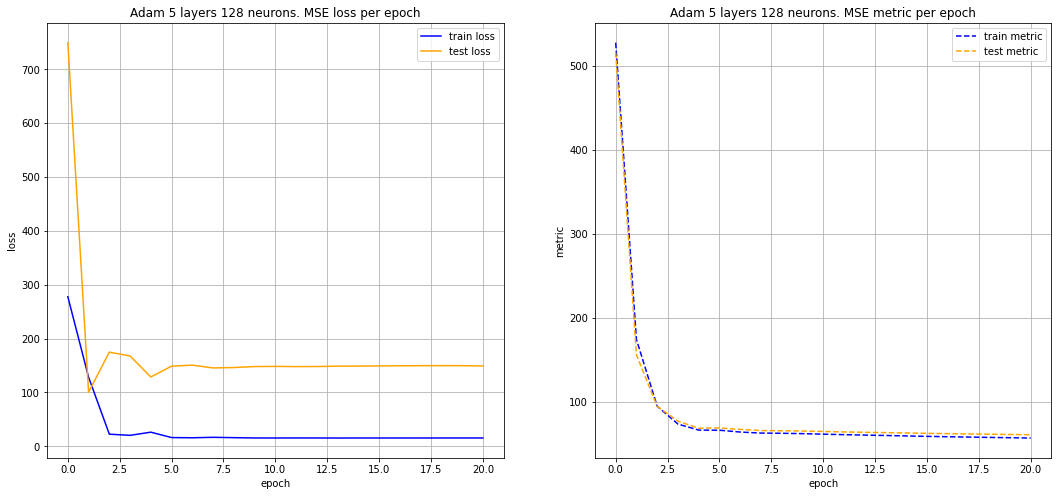

In [12]:
# Берем лучшую по r2 модель и рисуем ее обучение
best_r2 = sorted(result, key=lambda x: x[5], reverse=True)[0]
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.plot(np.arange(0, EPOCHS), best_r2[1], color='blue', label='train loss')
plt.plot(np.arange(0, EPOCHS), best_r2[2], color='orange', label='test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.title(f"{best_r2[0][2]().get_config()['name']} {best_r2[0][0]} layers {best_r2[0][1]} neurons. MSE loss per epoch")
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, EPOCHS), best_r2[3], color='blue', ls='dashed', label='train metric')
plt.plot(np.arange(0, EPOCHS), best_r2[4], color='orange', ls='dashed', label='test metric')
plt.xlabel('epoch')
plt.ylabel('metric')
plt.grid()
plt.title(f"{best_r2[0][2]().get_config()['name']} {best_r2[0][0]} layers {best_r2[0][1]} neurons. MSE metric per epoch")
plt.legend(loc='best')

plt.show()

In [13]:
result = []
EPOCHS = 101
for par in combined_params:
    model = create_model(INPUT_SHAPE, par[0], par[1])
    optimizer = par[2]()

    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []

    for epoch in range(EPOCHS):
        print("\nepoch {}/{}".format(epoch + 1, EPOCHS))
        pb_train = Progbar(len(train_ds), stateful_metrics=['MSE loss', 'MSE metric'])
        pb_test = Progbar(len(test_ds), stateful_metrics=['MSE loss', 'MSE metric'])

        metric.reset_state()
        # проход по всем батчам трейновой выборки
        for train_x, train_y in train_ds:
            train_result = train_step(train_x, train_y)
            values=[('MSE loss',train_result[0].numpy()), ('MSE metric',train_result[0].numpy())]
            pb_train.add(1, values=values)
        
        # логи
        train_loss.append(train_result[0].numpy())
        train_acc.append(train_result[1].numpy())

        # проход по всем батчам тестовой выборки
        for test_x, test_y in test_ds:
            test_result = test_step(test_x, test_y)
            values=[('MSE loss',test_result[0].numpy()), ('MSE metric',test_result[0].numpy())]
            pb_test.add(1, values=values)
        
        # логи
        test_loss.append(test_result[0].numpy())
        test_acc.append(test_result[1].numpy())
    
    y_test_pred = model.predict(X_test).flatten()
    r2 = r2_score(y_test, y_test_pred)

    result.append((par, train_loss, test_loss, train_acc, test_acc, r2))
    clear_output()
    print(f"{optimizer.get_config()['name']} || levels: {par[0]} || neurons: {par[1]} || r2 score: {r2:.4f}")

Adam || levels: 10 || neurons: 128 || r2 score: 0.5994


In [14]:
# Выведем сводную таблицу скоров r2 для всех моделей
print(f'Epochs: {EPOCHS}')
for i in range(3):
    print(46 * '=')
    print(f"{result[i * 9][0][2]().get_config()['name']} {25 * ' '} r2 score")
    print(46 * '=')
    print(pd.DataFrame(np.array([res[5] for res in result[i * 9: (i + 1) * 9]]).reshape(3, 3), 
                       index=['2 layers', '5 layers', '10 layers'], 
                       columns=['32 neurons', '64 neurons', '128 neurons']))

Epochs: 101
RMSprop                           r2 score
           32 neurons  64 neurons  128 neurons
2 layers     0.369696    0.500799     0.626136
5 layers     0.544781    0.516277     0.549381
10 layers    0.531415    0.587729     0.200126
Nadam                           r2 score
           32 neurons  64 neurons  128 neurons
2 layers     0.387834    0.533507     0.654305
5 layers     0.633906    0.625238     0.637362
10 layers    0.625175    0.631134     0.648875
Adam                           r2 score
           32 neurons  64 neurons  128 neurons
2 layers     0.369719    0.555829     0.652438
5 layers     0.642007    0.606409     0.642854
10 layers    0.624490    0.610688     0.599393


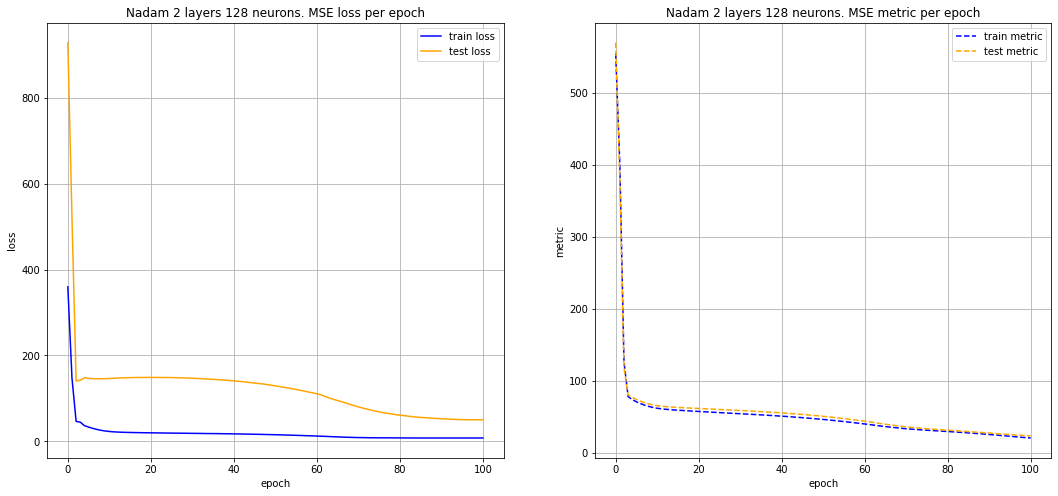

In [15]:
# Берем лучшую по r2 модель и рисуем ее обучение
best_r2 = sorted(result, key=lambda x: x[5], reverse=True)[0]
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.plot(np.arange(0, EPOCHS), best_r2[1], color='blue', label='train loss')
plt.plot(np.arange(0, EPOCHS), best_r2[2], color='orange', label='test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.title(f"{best_r2[0][2]().get_config()['name']} {best_r2[0][0]} layers {best_r2[0][1]} neurons. MSE loss per epoch")
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, EPOCHS), best_r2[3], color='blue', ls='dashed', label='train metric')
plt.plot(np.arange(0, EPOCHS), best_r2[4], color='orange', ls='dashed', label='test metric')
plt.xlabel('epoch')
plt.ylabel('metric')
plt.grid()
plt.title(f"{best_r2[0][2]().get_config()['name']} {best_r2[0][0]} layers {best_r2[0][1]} neurons. MSE metric per epoch")
plt.legend(loc='best')

plt.show()

**Выводы**  

- Значительного буста в метрике можно добиться подходящим к задаче выбором оптимизатора
- Архитектура сети играет важную роль, но с увеличением количества слоев, может потребоваться значительно большее количество эпох для обучения. Также не следует забывать про затухание градиента и выбор функции активации
- Не всегда следует использовать нейронки. В простых задачах лучше может отработать алгоритм из классического ML

In [17]:
# Простейший бейзлайн на линейной регрессии
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
r2_score(y_test, regressor.predict(X_test))

0.7817795450774275